In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from datetime import datetime as dt
from copy import deepcopy
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from attacks import fgsm, pgd
from model import SmallIntervalNet
from layers import *

1.7.0
True


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def copy_model(Model, old):
    new_model = Model().to(device)
    for layer, old_layer in zip(new_model.children(), old.children()):
        print(layer)
        layer.weight.data = old_layer.weight.data.clone()
    return new_model

def pgd(model, X, y, loss_fn, epsilon=0.1, alpha=0.01, num_iter=20):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.grad.zero_()
    return delta.detach()


from datetime import datetime as dt

def clean_acc(model, loader):
    clean_correct = 0.
    model.eval()
    with torch.no_grad():
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(device), y.to(device)  
            clean_correct += (model(X).argmax(dim=1) == y).sum().item()
            end = dt.now().replace(microsecond=0)
            print(f"iter: {k}/{len(loader)} time: {end-start}", end="\r")
        print(" " * 50, end="\r")
        acc = round(clean_correct / len(loader.dataset), 4)
        print(f"clean accuracy: {acc}")
    return acc

def adv_acc(model, loader, loss_fn, attack, attack_params):
    model.eval()
    adv_correct = [0] * len(attack_params)
    for i, (name, params) in enumerate(attack_params):
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(device), y.to(device)
            noise = attack(model, X, y, loss_fn, **params)
            out = model(X+noise)
            adv_correct[i] += (out.argmax(dim=1) == y).sum().item()
            end = dt.now().replace(microsecond=0)
            print(f"iter: {k}/{len(loader)} time: {end-start}", end="\r")
        print(" " * 50, end="\r")
        print(f"name: {name} accuracy: {(adv_correct[i] / len(loader.dataset)):.4f}")
    return [round(a/len(loader.dataset), 4) for a in adv_correct]


def print_table(models, attacks, clean, adv):
    d = {'model': models, 'clean image': clean}
    for i, (name, p) in enumerate(attacks):
        d[name] = [adv[j][i] for j, _ in enumerate(adv)]

    return pd.DataFrame(data=d)

In [5]:
seed = torch.seed()
print(f"seed: {seed}")
torch.manual_seed(seed)

seed: 3497842552852609740


In [6]:
import re
import os
from datetime import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class Trainer:

    def __init__(self, model_name, train_dataset, test_dataset, batch_size=(200, 200)):
        self.batch_size = batch_size
        self.train_dl = DataLoader(train_dataset, batch_size=batch_size[0], shuffle=True)
        self.test_dl = DataLoader(test_dataset, batch_size=batch_size[1], shuffle=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.logs = {}
        self.eps, self.kappa = 0, 1
        self.interval_train = False
        self.model_name = model_name
        self.checkpoint_path = "saved/{}/{}_{}_checkpoint.pt"
        os.makedirs(f"saved/{model_name}/", exist_ok=True)

    def _interval_based_bound(self, model, c, bounds, idx):
        # requires last layer to be linear
        cW = c.t() @ (model.last_layer.weight - self.eps)
        cb = c.t() @ model.last_layer.bias
        l, u = bounds
        return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:, None]).t()


    def _train_test_epoch(self, model, loader, loss_fn, optimizer=None):
        C = [-torch.eye(10).to(self.device) for _ in range(10)]
        for y0 in range(10):
            C[y0][y0, :] += 1

        robust_err = 0
        total_loss, accuracy = 0., 0.
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(self.device), y.to(self.device)
            if optimizer is None:
                out = model(X)
            else:
                out = model(torch.cat([X, X], dim=1))
            fit_loss = self.kappa * loss_fn(out, y)
            accuracy += (out.argmax(dim=1) == y).sum().item()

            robust_loss = 0
            for y0 in range(10):
                if sum(y == y0) > 0:
                    lower_bound = self._interval_based_bound(model, C[y0], model.bounds, y == y0)
                    robust_loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y == y0]) / X.shape[0]

                    # increment when true label is not winning
                    robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item()

            # combined losss
            combined_loss = self.kappa * fit_loss + (1 - self.kappa) * robust_loss

            if optimizer is not None:
                optimizer.zero_grad()
                combined_loss.backward()
                optimizer.step()
                
                if self.eps < 0.1:
                    self.eps += 0.000008333
                    model.set_eps(self.eps)

                if self.kappa > 0.5:
                    self.kappa -= 0.000020833
                else:
                    self.kappa = 0.5

            total_loss += combined_loss.data.item() * X.size(0)
            end = dt.now().replace(microsecond=0)
            print(f"{self.phase_name} iteration: {k}/{len(loader)} time: {end - start}", end="\r")

            
        print(" " * 80, end="\r")

        return total_loss/len(loader.dataset), accuracy/len(loader.dataset), robust_err/len(loader.dataset)

    def _train(self, model, loss_fn, optimizer):
        model.train()
        self.phase_name = "train"
        with torch.enable_grad():
            return self._train_test_epoch(model, self.train_dl, loss_fn, optimizer)

    def _test(self, model, loss_fn):
        model.eval()
        self.phase_name = "test"
        with torch.no_grad():
            return self._train_test_epoch(model, self.test_dl, loss_fn)

    def train(self, model, loss_fn, optimizer, scheduler=None, epochs=30, patience=4):
        self.logs = {
            'loss': {"train": [], "test": []},
            'accuracy': {"train": [], "test": []},
            'robust error': {"train": [], "test": []},
        }
        model = model.to(self.device)
        epochs_no_improve, min_loss = np.inf, float('inf')
        min_robust_err = float('inf')

        for e in range(1, epochs+1):
            start = dt.now().replace(microsecond=0)
            print(f"epoch start with: eps: {self.eps:.8f}, kappa: {self.kappa:.8f}")
            train_loss, train_acc, train_err = self._train(model, loss_fn, optimizer)
            test_loss, test_acc, test_err = self._test(model, loss_fn)
            followed_metric = test_loss
            if scheduler is not None:
                scheduler.step(followed_metric)
            end = dt.now().replace(microsecond=0)
            out = "Epoch: {} Validation Loss: {:.4f} accuracy: {:.4f}, robust err: {:.4f}, time: {}"
            print(out.format(e, test_loss, test_acc, test_err, end - start), end="\n\n")

            # Update logs
            self.logs['loss']["train"].append(train_loss)
            self.logs['loss']["test"].append(test_loss)
            self.logs['accuracy']["train"].append(train_acc)
            self.logs['accuracy']["test"].append(test_acc)
            self.logs['robust error']["train"].append(train_err)
            self.logs['robust error']["test"].append(test_err)

            torch.save(model.state_dict(), self.checkpoint_path.format(self.model_name, self.model_name, str(e)))

        return self.logs


def plot_history(model_name, hists):
    x = np.arange(1, len(hists["loss"]["test"]) + 1)
    f, axes = plt.subplots(nrows=1, ncols=len(hists), figsize=(15, 5))
    for ax, (name, hist) in zip(axes, hists.items()):
        for label, h in hist.items():
            ax.plot(x, h, label=label)

        ax.set_title("Model " + name)
        ax.set_xlabel('epochs')
        ax.set_ylabel(name)
        ax.legend(loc="best")

    f.savefig(f"{model_name}.png", dpi=f.dpi)
    plt.show()

In [7]:
tr_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = MNIST('../data', train=True, download=True, transform=tr_transform)
ds_test = MNIST('../data', train=False, download=True, transform=vl_transform)

In [8]:
from interval_layers import LinearInterval, Conv2dInterval

class Small(nn.Module):

    def __init__(self, eps=0):
        super().__init__()
        self.conv1 = Conv2dInterval(1, 16, 4, 2, eps=eps)
        self.conv2 = Conv2dInterval(16, 32, 4, 1, eps=eps)
        self.fc1 = LinearInterval(32*10*10, 100, eps=eps)
        self.last_layer = LinearInterval(100, 10, eps=eps)

        self.bounds = None

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = f.relu(self.fc1(x))
        if self.training:
            self.bounds = x[:, :x.size(1)// 2], x[:, x.size(1)//2:]
        x = self.last_layer(x)
        return ((x[:, :x.size(1)// 2] + x[:, x.size(1)//2:])/2) if self.training else x

    def bounds(self):
        return self.bounds
    
    def set_eps(self, eps):
        for layer in self.children():
            layer.eps = eps

cuda
epoch start with: eps: 0.00000000, kappa: 1.00000000
Epoch: 1 Validation Loss: 0.6091 accuracy: 0.9157, robust err: 1.0000, time: 0:01:14

epoch start with: eps: 0.00499980, kappa: 0.98750020
Epoch: 2 Validation Loss: 2.5592 accuracy: 0.2236, robust err: 1.0000, time: 0:01:13

epoch start with: eps: 0.00999960, kappa: 0.97500040
Epoch: 3 Validation Loss: 2.8116 accuracy: 0.1010, robust err: 1.0000, time: 0:01:18

epoch start with: eps: 0.01499940, kappa: 0.96250060
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.                   
Epoch: 4 Validation Loss: 3.1094 accuracy: 0.1135, robust err: 1.0000, time: 0:01:17

epoch start with: eps: 0.01999920, kappa: 0.95000080
Epoch: 5 Validation Loss: 3.3280 accuracy: 0.1135, robust err: 0.9909, time: 0:01:17

epoch start with: eps: 0.02499900, kappa: 0.93750100
Epoch: 6 Validation Loss: 3.5190 accuracy: 0.1135, robust err: 0.9869, time: 0:01:19

epoch start with: eps: 0.02999880, kappa: 0.92500120
Epoch: 7 Validation Loss: 3

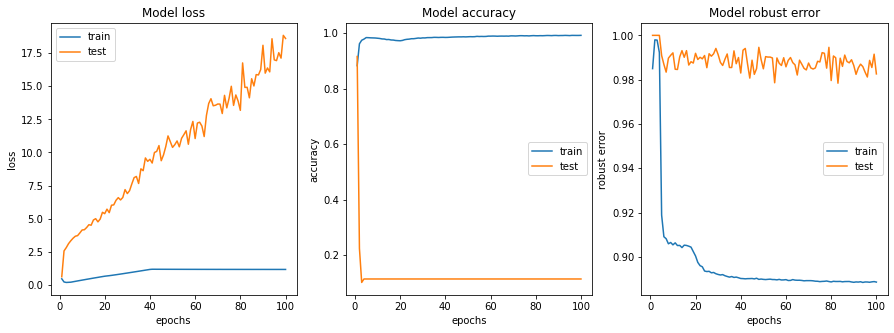

In [9]:
model_name = "mnist_small_relu"

trainer = Trainer(model_name, ds_train, ds_test, batch_size=(100, 100))
model = Small()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-4,
                                                 patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=100, patience=6)
plot_history(model_name, history)
torch.save(model.state_dict(), f"saved/{model_name}/{model_name}_final.pt")

In [10]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

ds = MNIST('../data', train=False, target_transform=None, download=True, transform=test_transform)
test_loader = DataLoader(ds, 200, shuffle=True)


def create_attack(eps, alpha, num_iter):
    d = {
        "epsilon": eps,
        "alpha": alpha,
        "num_iter": num_iter
    }
    return f"e={eps:.1f},a={alpha:.1f},i={num_iter}", d
    

attack1 = create_attack(eps=0.1, alpha=0.1, num_iter=30)
attack2 = create_attack(eps=0.2, alpha=0.1, num_iter=30)
attack3 = create_attack(eps=0.3, alpha=0.1, num_iter=30)
attack4 = create_attack(eps=0.4, alpha=0.1, num_iter=30)

params = [attack1, attack2, attack3, attack4]

In [11]:
clean, adv = [], []

model_name = "mnist_small_relu"

model = Small().to(device)
model.load_state_dict(torch.load(f"saved/{model_name}/{model_name}_1_checkpoint.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.9157                            
name: e=0.1,a=0.1,i=30 accuracy: 0.4650           
name: e=0.2,a=0.1,i=30 accuracy: 0.0428           
name: e=0.3,a=0.1,i=30 accuracy: 0.0001           
name: e=0.4,a=0.1,i=30 accuracy: 0.0000           
name: e=0.5,a=0.1,i=30 accuracy: 0.0000           


In [14]:
clean, adv = [], []

model_name = "mnist_small_relu"

model = Small().to(device)
model.load_state_dict(torch.load(f"saved/{model_name}/{model_name}_2_checkpoint.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.2236                            
name: e=0.1,a=0.1,i=30 accuracy: 0.1011           
name: e=0.2,a=0.1,i=30 accuracy: 0.1009           
name: e=0.3,a=0.1,i=30 accuracy: 0.1009           
name: e=0.4,a=0.1,i=30 accuracy: 0.1009           
name: e=0.5,a=0.1,i=30 accuracy: 0.1009           


In [13]:
clean, adv = [], []

model_name = "mnist_small_relu"

model = Small().to(device)
model.load_state_dict(torch.load(f"saved/{model_name}/{model_name}_5_checkpoint.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.1135                            
name: e=0.1,a=0.1,i=30 accuracy: 0.1135           
name: e=0.2,a=0.1,i=30 accuracy: 0.1135           
name: e=0.3,a=0.1,i=30 accuracy: 0.1135           
name: e=0.4,a=0.1,i=30 accuracy: 0.1135           
name: e=0.5,a=0.1,i=30 accuracy: 0.1135           


In [12]:
clean, adv = [], []

model_name = "mnist_small_relu"

model = Small().to(device)
model.load_state_dict(torch.load(f"saved/{model_name}/{model_name}_10_checkpoint.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.1135                            
name: e=0.1,a=0.1,i=30 accuracy: 0.1135           
name: e=0.2,a=0.1,i=30 accuracy: 0.1135           
name: e=0.3,a=0.1,i=30 accuracy: 0.1135           
name: e=0.4,a=0.1,i=30 accuracy: 0.1135           
name: e=0.5,a=0.1,i=30 accuracy: 0.1135           


In [15]:
clean, adv = [], []

model_name = "mnist_small_relu"

model = Small().to(device)
model.load_state_dict(torch.load(f"saved/{model_name}/{model_name}_50_checkpoint.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.1135                            
name: e=0.1,a=0.1,i=30 accuracy: 0.1135           
name: e=0.2,a=0.1,i=30 accuracy: 0.1135           
name: e=0.3,a=0.1,i=30 accuracy: 0.1135           
name: e=0.4,a=0.1,i=30 accuracy: 0.1135           
name: e=0.5,a=0.1,i=30 accuracy: 0.1135           


In [16]:
clean, adv = [], []

model_name = "mnist_small_relu"

model = Small().to(device)
model.load_state_dict(torch.load(f"saved/{model_name}/{model_name}_100_checkpoint.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.1135                            
name: e=0.1,a=0.1,i=30 accuracy: 0.1135           
name: e=0.2,a=0.1,i=30 accuracy: 0.1135           
name: e=0.3,a=0.1,i=30 accuracy: 0.1135           
name: e=0.4,a=0.1,i=30 accuracy: 0.1135           
name: e=0.5,a=0.1,i=30 accuracy: 0.1135           
